# Maching Learning Model to Predict Amount of Gold Recovered from Gold Ore

## Introduction

The goal of this project is to build a machine learning project to predict the amount of gold recovered from gold ore, for Zyfra who develops efficiency solutions for mining, oil & gas, chemical and engineering industries.
We have data on extraction and purification, stored in three files, a training dataset, a test dataset, and the original source dataset. First the data will be examined and prepared, and recovery will be calculated from the features and those values compared with the recovery given in the data. The features from training and test sets will be compared, and then we will proceed with data preprocessing: adding missing targets to test set, changing data type where appropriate, checking for and filling in missing values. After this we'll take a look at some feature distributions, namely the particle feed size, and the total concentrations of substances at different stages of the purification process. Finally different models will be built and evaluated using symmetric Mean Absolute Percentage Error.

## Data Preparation

### Opening the files

In [1]:
!pip install -U sidetable

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 2.5 MB/s eta 0:00:01


In [2]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor

%matplotlib inline

In [3]:
try:
    reco_train =  pd.read_csv('/datasets/gold_recovery_train.csv')
    reco_test =  pd.read_csv('/datasets/gold_recovery_test.csv')
    reco_full =  pd.read_csv('/datasets/gold_recovery_full.csv')
except:
    print('Error in importing the csv file to Pandas.')

In [4]:
reco_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
reco_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
reco_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [7]:
reco_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [8]:
reco_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [9]:
reco_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


The training set contains 16860 entries, with a total of 87 columns. The test set contains 5856 entries and 53 columns, so less features than the training set. The full data contains 22716 entries and 87 columns. All features are floats except for the date, which will be converted to datetime later.

### Calculating Recovery from Features and Comparing it to Recovery Feature

In [10]:
#Creating a new dataframe with the recovery feature, and calculating the recovery from other
#features to compare the two.

reco_calc = pd.DataFrame()
reco_calc['rougher.output.recovery'] = reco_train['rougher.output.recovery']

reco_calc['reco_calculated'] = 100 * reco_train['rougher.output.concentrate_au'] * \
(reco_train['rougher.input.feed_au'] - reco_train['rougher.output.tail_au']) / \
(reco_train['rougher.input.feed_au'] * (reco_train['rougher.output.concentrate_au'] - reco_train['rougher.output.tail_au']))

In [11]:
reco_calc.head()

,rougher.output.recovery,reco_calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


Let's check if our calculations introduced any infinity values and get rid of those:

In [12]:
np.isinf(reco_calc['reco_calculated']).sum()

30

In [13]:
#Changing the infinity values to NaN, and then removing all NaN from the reco_calc dataframe.

with pd.option_context('mode.use_inf_as_na', True):
    reco_calc.dropna(inplace=True)

In [14]:
np.isinf(reco_calc['reco_calculated']).sum()

0

In [15]:
mean_absolute_error(reco_calc['rougher.output.recovery'], reco_calc['reco_calculated'])

1.1101950495226952e-14

The mean absolute error is small so the recovery feature corresponds for the most part to the values calculated from the other features using the real formula for the recovery.

### Comparing Features in Test and Train sets

Features not available in the test set:

In [16]:
#Creating a list of features that are in training set but missing from test set.

train_not_test = list(set(reco_train.columns) - set(reco_test.columns))
train_not_test.sort()
train_not_test

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

All the output features are not in the test set. The two targets features rougher.output.recovery and final.output.recovery are missing from the test set so we will need to add those in the next section.

### Data Preprocessing

#### Adding targets to test set

In [17]:
reco_test = reco_test.merge(
    reco_full[['date', 'rougher.output.recovery', 'final.output.recovery']], \
    how='left', on='date')

In [18]:
reco_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

#### Changing Date Type

In [19]:
reco_test['date'] = pd.to_datetime(reco_test['date'])
reco_train['date'] = pd.to_datetime(reco_train['date'])

#### Checking for Missing Values 

In [20]:
reco_train.stb.missing(style=True)

,missing,total,percent
rougher.output.recovery,"2,573","16,860",15.26%
rougher.output.tail_ag,"2,250","16,860",13.35%
rougher.output.tail_sol,"2,249","16,860",13.34%
rougher.output.tail_au,"2,249","16,860",13.34%
secondary_cleaner.output.tail_sol,"1,986","16,860",11.78%
rougher.input.floatbank11_xanthate,"1,904","16,860",11.29%
final.output.recovery,"1,521","16,860",9.02%
primary_cleaner.input.sulfate,"1,307","16,860",7.75%
primary_cleaner.input.depressant,"1,262","16,860",7.49%
rougher.calculation.au_pb_ratio,"1,242","16,860",7.37%


In [21]:
reco_test.stb.missing(style=True)

,missing,total,percent
rougher.output.recovery,546,"5,856",9.32%
final.output.recovery,442,"5,856",7.55%
rougher.input.floatbank11_xanthate,353,"5,856",6.03%
primary_cleaner.input.sulfate,302,"5,856",5.16%
primary_cleaner.input.depressant,284,"5,856",4.85%
rougher.input.floatbank10_sulfate,257,"5,856",4.39%
primary_cleaner.input.xanthate,166,"5,856",2.83%
rougher.input.floatbank10_xanthate,123,"5,856",2.10%
rougher.input.feed_sol,67,"5,856",1.14%
rougher.input.floatbank11_sulfate,55,"5,856",0.94%


Almost all features have missing values, as well as the targets. We first need to remove rows that have missing values for the target variables.

In [22]:
#Removing rows in test and training sets that have missing target values.

reco_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
reco_test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

In [23]:
reco_train.stb.missing(style=True)

,missing,total,percent
secondary_cleaner.output.tail_sol,"1,605","14,149",11.34%
rougher.state.floatbank10_e_air,436,"14,149",3.08%
rougher.input.floatbank11_xanthate,428,"14,149",3.02%
primary_cleaner.output.concentrate_sol,286,"14,149",2.02%
secondary_cleaner.state.floatbank2_a_air,217,"14,149",1.53%
final.output.concentrate_sol,211,"14,149",1.49%
rougher.input.feed_size,144,"14,149",1.02%
primary_cleaner.input.xanthate,100,"14,149",0.71%
rougher.input.feed_pb,100,"14,149",0.71%
final.output.tail_pb,100,"14,149",0.71%


In [24]:
reco_test.stb.missing(style=True)

,missing,total,percent
rougher.input.floatbank11_xanthate,25,"5,290",0.47%
rougher.input.feed_sol,21,"5,290",0.40%
secondary_cleaner.state.floatbank3_a_air,9,"5,290",0.17%
rougher.input.floatbank11_sulfate,8,"5,290",0.15%
primary_cleaner.input.depressant,5,"5,290",0.09%
rougher.input.floatbank10_sulfate,5,"5,290",0.09%
primary_cleaner.input.xanthate,4,"5,290",0.08%
primary_cleaner.input.sulfate,4,"5,290",0.08%
secondary_cleaner.state.floatbank2_a_air,3,"5,290",0.06%
rougher.input.feed_rate,3,"5,290",0.06%


Let's now fill the remaining missing values with the last valid observation as entries close in time oftentimes have similar values. First we need to make sure the dataframes are ordered by date.

In [25]:
reco_train.sort_values('date', inplace=True)
reco_test.sort_values('date', inplace=True)

In [26]:
reco_train.ffill(inplace=True)
reco_test.ffill(inplace=True)

#### Checking for Duplicates

In [27]:
reco_train.duplicated().sum()

0

In [28]:
reco_test.duplicated().sum()

0

## Analysis of the Data

### Changes in the Concentration of Metals  During Purification Stage

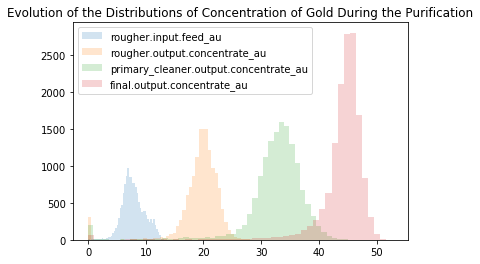

In [29]:
data_au = reco_train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]

plt.hist(data_au['rougher.input.feed_au'], alpha=.2, bins=50)
plt.hist(data_au['rougher.output.concentrate_au'], alpha=.2, bins=50)
plt.hist(data_au['primary_cleaner.output.concentrate_au'], alpha=.2, bins=50)
plt.hist(data_au['final.output.concentrate_au'], alpha=.2, bins=50)
plt.legend(['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'])
plt.title('Evolution of the Distributions of Concentration of Gold During the Purification')
plt.show()

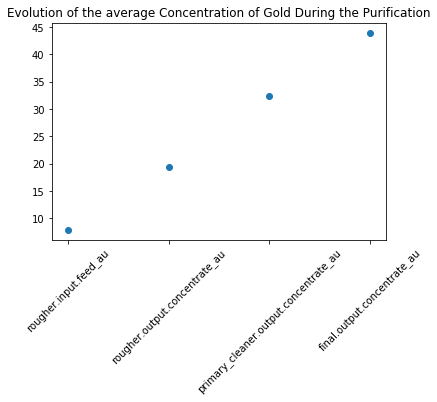

In [30]:
x = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
y = [data_au['rougher.input.feed_au'].mean(), data_au['rougher.output.concentrate_au'].mean(), data_au['primary_cleaner.output.concentrate_au'].mean(), data_au['final.output.concentrate_au'].mean()]
plt.scatter(x,y)
plt.title('Evolution of the average Concentration of Gold During the Purification')
plt.xticks(rotation=45)
plt.show()

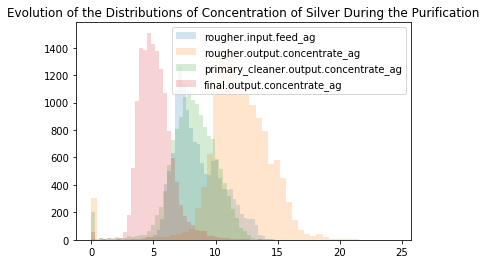

In [31]:
data_ag = reco_train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]

plt.hist(data_ag['rougher.input.feed_ag'], alpha=.2, bins=50)
plt.hist(data_ag['rougher.output.concentrate_ag'], alpha=.2, bins=50)
plt.hist(data_ag['primary_cleaner.output.concentrate_ag'], alpha=.2, bins=50)
plt.hist(data_ag['final.output.concentrate_ag'], alpha=.2, bins=50)
plt.legend(['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'])
plt.title('Evolution of the Distributions of Concentration of Silver During the Purification')
plt.show()

Since it's difficult to distinguish the rougher input feed from the primary cleaner output concentrate as those distributions are close, let's look at how the mean values change at each stage of the purification process.

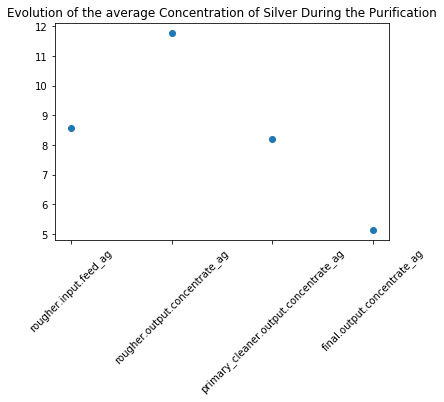

In [32]:
x = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
y = [data_ag['rougher.input.feed_ag'].mean(), data_ag['rougher.output.concentrate_ag'].mean(), data_ag['primary_cleaner.output.concentrate_ag'].mean(), data_ag['final.output.concentrate_ag'].mean()]
plt.scatter(x,y)
plt.title('Evolution of the average Concentration of Silver During the Purification')
plt.xticks(rotation=45)
plt.show()

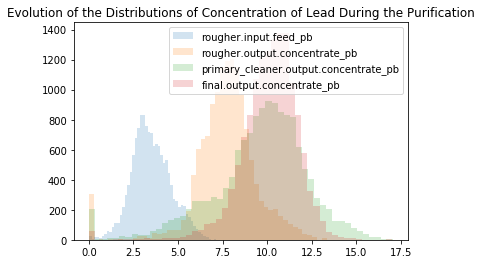

In [33]:
data_pb = reco_train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

plt.hist(data_pb['rougher.input.feed_pb'], alpha=.2, bins=50)
plt.hist(data_pb['rougher.output.concentrate_pb'], alpha=.2, bins=50)
plt.hist(data_pb['primary_cleaner.output.concentrate_pb'], alpha=.2, bins=50)
plt.hist(data_pb['final.output.concentrate_pb'], alpha=.2, bins=50)
plt.legend(['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'])
plt.title('Evolution of the Distributions of Concentration of Lead During the Purification')
plt.show()

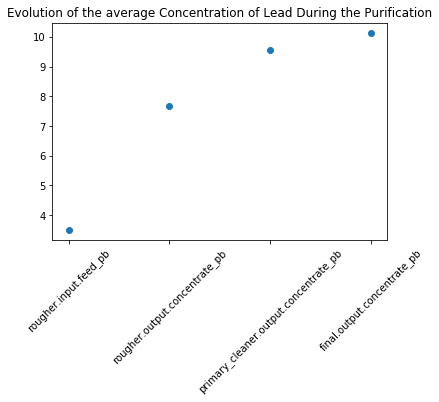

In [34]:
x = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
y = [data_pb['rougher.input.feed_pb'].mean(), data_pb['rougher.output.concentrate_pb'].mean(), data_pb['primary_cleaner.output.concentrate_pb'].mean(), data_pb['final.output.concentrate_pb'].mean()]
plt.scatter(x,y)
plt.title('Evolution of the average Concentration of Lead During the Purification')
plt.xticks(rotation=45)
plt.show()

The concentration of gold and lead increases after each purification stage. The silver concentration increases after the first stage, and then decreases each time.

### Feed Particle Size Distributions Comparison

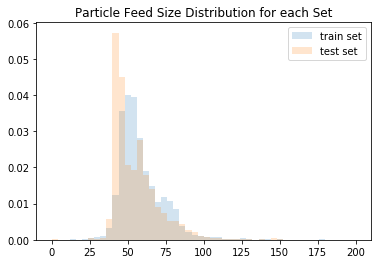

In [35]:
plt.hist(reco_train['rougher.input.feed_size'], density=True, alpha=.2, bins=50, range=(0,200))
plt.hist(reco_test['rougher.input.feed_size'], density=True, alpha=.2, bins=50, range=(0,200))
plt.legend(['train set', 'test set'])
plt.title('Particle Feed Size Distribution for each Set')
plt.show()

Looking at the graph, the difference of the distributions is not significant.

### Total Concentrations of all Substances at Different Stages of the Recovery Process

In [36]:
all_substances = pd.DataFrame()
all_substances['feed'] = (reco_train['rougher.input.feed_au'] + \
                          reco_train['rougher.input.feed_ag'] + \
                          reco_train['rougher.input.feed_pb'] + \
                          reco_train['rougher.input.feed_sol']
                         )

all_substances['concentrate'] = (reco_train['rougher.output.concentrate_au'] + \
                          reco_train['rougher.output.concentrate_ag'] + \
                          reco_train['rougher.output.concentrate_pb'] + \
                          reco_train['rougher.output.concentrate_sol']
                         )

all_substances['final'] = (reco_train['final.output.concentrate_au'] + \
                          reco_train['final.output.concentrate_ag'] + \
                          reco_train['final.output.concentrate_pb'] + \
                          reco_train['final.output.concentrate_sol']
                         )

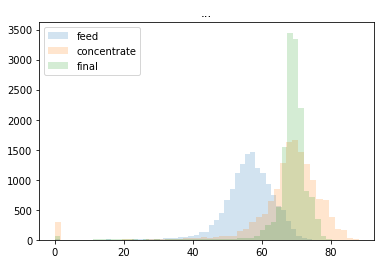

In [37]:
plt.hist(all_substances['feed'], alpha=.2, bins=50)
plt.hist(all_substances['concentrate'], alpha=.2, bins=50)
plt.hist(all_substances['final'], alpha=.2, bins=50)
plt.legend(['feed', 'concentrate', 'final'])
plt.title('...')
plt.show()

In [38]:
#Selecting rows from the all_substances dataframe that have a null concentration at one or more 
#stages of purification in the training set.

zeros = (all_substances[(all_substances['feed'] == 0) | \
                        (all_substances['concentrate'] == 0) | \
                        (all_substances['final'] == 0)]
        )

print('There are {} entries where substances concentrations are null during one or more stage of purification.'.format(zeros.shape[0]))

There are 354 entries where substances concentrations are null during one or more stage of purification.


In [39]:
index_zeros = zeros.index

Let's check the same for the test set, however since the test set doesn't contain the output concentrate features, we will just check the substances concentration for the input feed.

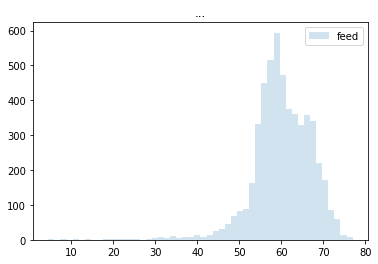

In [40]:
all_substances_test = pd.DataFrame()
all_substances_test['feed'] = (reco_test['rougher.input.feed_au'] + \
                          reco_test['rougher.input.feed_ag'] + \
                          reco_test['rougher.input.feed_pb'] + \
                          reco_test['rougher.input.feed_sol']
                         )
plt.hist(all_substances_test['feed'], alpha=.2, bins=50)
plt.legend(['feed'])
plt.title('...')
plt.show()

In [41]:
len(all_substances_test[all_substances_test['feed'] == 0])

0

No null values for the total concentration of substances in the input feed for the test set, however, there are some zero values in the distribution of all substances at some of the purification stages for the training set, so let's remove all those zeros values since this won't be useful for our model.

In [42]:
print('Percentage of rows with null substances concentration in training set: {:.2%}'.format(len(index_zeros)/len(reco_train.index)))

Percentage of rows with null substances concentration in training set: 2.50%


In [43]:
reco_train.drop(index=index_zeros, inplace=True)

## Building the Model

### SMAPE Calculation

A function for calculating the sMAPE (symmetric Mean Absolute Percentage Error) score is first defined, and then we calculate the final sMAPE score adding 25% of the rougher output recovery sMAPE score to 75% of the final output recovery sMAPE score, and we convert this final sMAPE score to a scorer using sklearn make_scorer for the cross validation.

In [44]:
def smape(target, preds):
    '''Calculates the symmetric Mean Absolute Percentage Error between target and predictions.
    
    target: array of target values
    preds: array of predicted values
    '''
    
    return np.mean(abs(target - preds) / ((abs(target) + abs(preds)) / 2))

In [45]:
def final_smape(target, preds):
    '''Calculates the final metric value which is 25% of the sMAPE score for rougher output plus
    75% of the sMAPE score for final output
    
    target: array of target values
    preds: array of predicted values'''
    
    smape_rougher = smape(target[:,0], preds[:,0])
    smape_final = smape(target[:,1], preds[:,1])
    return (0.25 * smape_rougher + 0.75 * smape_final)

In [46]:
#Creating the scorer for cross validation.

smape_score = make_scorer(final_smape, greater_is_better=False)

### Linear Regression

In [47]:
# Keeping only the features that are in both the training set and the test set.

features = list(set(reco_train.columns).intersection(set(reco_test.columns)) 
                - set(['date', 'rougher.output.recovery', 'final.output.recovery']))

target = ['rougher.output.recovery', 'final.output.recovery']

features_train, features_test = reco_train[features].values, reco_test[features].values
target_train, target_test = reco_train[target].values, reco_test[target].values

We use MinMaxScaler here to scale the features as Standard Scaler introduced some nan in the calculation of the smape score.

In [48]:
pipe = Pipeline([("scale", MinMaxScaler()),
                 ("Linear Regression", LinearRegression())
                ])

In [62]:
# Cross validation for the linear regression model, using 3 folds as we will use 3 folds (to take less time) in GridSearchCV for other models

scores_lr = cross_val_score(pipe, features_train, target_train, cv=3, scoring=smape_score)
print('Mean smape score for linear regression model: {}'.format(np.mean(scores_lr)))

Mean smape score for linear regression model: -0.1264042505483007


### Decision Tree Regression

In [50]:
parameters = {
    'max_depth': [1,3,5,7,11]
}
model_dt = DecisionTreeRegressor(random_state=12345)
dt = GridSearchCV(model_dt, parameters, scoring=smape_score, verbose=3)

dt.fit(features_train, target_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=1 .....................................................
[CV] ........................ max_depth=1, score=-0.096, total=   0.1s
[CV] max_depth=1 .....................................................


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ........................ max_depth=1, score=-0.107, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] ........................ max_depth=1, score=-0.109, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ........................ max_depth=3, score=-0.097, total=   0.2s
[CV] max_depth=3 .....................................................
[CV] ........................ max_depth=3, score=-0.102, total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ........................ max_depth=3, score=-0.115, total=   0.1s
[CV] max_depth=5 .....................................................
[CV] ........................ max_depth=5, score=-0.116, total=   0.2s
[CV] max_depth=5 .....................................................
[CV] ........................ max_depth=5, score=-0.089, total=   0.2s
[CV] max_depth=5 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.5s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=12345,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(final_smape, greater_is_better=False),
 

In [51]:
dt.best_score_

-0.10404073043544523

The decision tree score is a little better than the linear regression one. Let's look at some random forest models now.

### Random Forest Regression

In [53]:
parameters = {
    'max_depth': [5,7,11],
    'n_estimators': [100,500],
}
model_rf = RandomForestRegressor(min_samples_leaf = 50, random_state=12345)

rf = GridSearchCV(model_rf, parameters, scoring=smape_score, verbose=3)

rf.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=5, n_estimators=100 ...................................
[CV] ...... max_depth=5, n_estimators=100, score=-0.094, total=  12.9s
[CV] max_depth=5, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s


[CV] ...... max_depth=5, n_estimators=100, score=-0.084, total=  12.8s
[CV] max_depth=5, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s


[CV] ...... max_depth=5, n_estimators=100, score=-0.128, total=  13.0s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ...... max_depth=5, n_estimators=500, score=-0.093, total= 1.1min
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ...... max_depth=5, n_estimators=500, score=-0.083, total= 1.1min
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ...... max_depth=5, n_estimators=500, score=-0.127, total= 1.1min
[CV] max_depth=7, n_estimators=100 ...................................
[CV] ...... max_depth=7, n_estimators=100, score=-0.093, total=  16.5s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] ...... max_depth=7, n_estimators=100, score=-0.082, total=  16.3s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] ...... max_depth=7, n_estimators=100, score=-0.128, total=  16.7s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 14.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=50,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=None,
    

In [54]:
rf.best_params_

{'max_depth': 7, 'n_estimators': 500}

In [55]:
rf.best_score_

-0.10082425897758526

### Best Model Score on Test Set and Comparison with Baseline model

The random forest regression model has the best score of all three models, so we will use this model on the test set and make predictions with it. 

In [57]:
predictions = rf.best_estimator_.predict(features_test)

print('Smape score for random forest regression model: {:.4f}'\
      .format(final_smape(target_test, predictions))
     )

Smape score for random forest regression model: 0.0918


Let's see how our model compares with a baseline model predicting the median target.

In [60]:
#Creating a baseline model that predicts the median and calculating its sMAPE score.

model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(features_train, target_train)
predictions = model_dummy.predict(features_test)

print('Smape score for baseline regression model: {:.4f}'\
      .format(final_smape(target_test, predictions))
     )

Smape score for baseline regression model: 0.0944


The random forest regression model with maximum depth of 7 and 500 trees, is only very slightly better than a baseline model always predicting the median of the targets. 

## Conclusion

The goal of this project was to build a machine learning project to predict the amount of gold recovered from gold ore, from data on extraction and purification, stored in three files, a training dataset, a test dataset, and the original source dataset. 

The training set contained 16860 entries, with a total of 87 columns. The test set had 5856 entries and 53 columns, and the full data 22716 entries and 87 columns. All variables were floats except for the date, which was converted to pandas datetime.
The recovery was calculated using the given features, and compared with the original recovery from the dataset, and we found that the difference between both was not significant. The two targets features rougher.output.recovery and final.output.recovery were missing from the test set so were added from the full dataset. Almost all features had missing values, and were filled with the last valid observation. The missing entries in targets were removed. No duplicates were found in the data.
The concentration of gold and lead increases after each purification stage, whereas the silver concentration increases after the first stage, and then decreases each time. Comparing particle feed size in the training set and test set, the difference of the distributions was not significant. However, there were some zero values in the distribution of all substances for the training set, and those were removed.

A function for calculating the sMAPE score was defined, and the final sMAPE score  was calculated by adding 25% of the rougher output recovery sMAPE score to 75% of the final output recovery sMAPE score. MinMaxScaler was used for linear regression. Linear regression, decision tree, and random forest models were evaluated on the sMAPE score using cross validation and we found that the random forest regression model had the best score of all three models.